# upload annotation json file

In [ ]:
import json

In [ ]:
ann_path = "/content/drive/MyDrive/captions_val2017.json"

with open(ann_path, "r") as f:
  data = json.load(f)

In [ ]:
from pycocotools.coco  import COCO
import os

# Extract filename and captions

In [ ]:
coco = COCO(ann_path)
folder = "/content/drive/MyDrive/captions "

path = os.path.join(folder, "captions_val2017.txt")

with open(path, "w") as f:
    for img_id in coco.getImgIds():
        img_info = coco.loadImgs(img_id)[0]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        ann_info = coco.loadAnns(ann_ids)
        for a in ann_info:
            f.write(img_info['file_name'] + "," + a['caption'] + "\n")

print(f"Captions saved to: {path}")

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Captions saved to: /content/drive/MyDrive/captions /captions_val2017.txt


# Save caption file

In [ ]:
with open("/content/drive/MyDrive/captions/captions_val2017.txt", "r") as f:
  captions = f.read()

In [ ]:
captions

'000000397133.jpg,A man is in a kitchen making pizzas.\n000000397133.jpg,Man in apron standing on front of oven with pans and bakeware\n000000397133.jpg,A baker is working in the kitchen rolling dough.\n000000397133.jpg,A person standing by a stove in a kitchen.\n000000397133.jpg,A table with pies being made and a person standing near a wall with pots and pans hanging on the wall.\n000000037777.jpg,The dining table near the kitchen has a bowl of fruit on it.\n000000037777.jpg,A small kitchen has various appliances and a table.\n000000037777.jpg,The kitchen is clean and ready for us to see.\n000000037777.jpg,A kitchen and dining area decorated in white.\n000000037777.jpg,A kitchen that has a bowl of fruit on the table.\n000000252219.jpg,a person with a shopping cart on a city street \n000000252219.jpg,City dwellers walk by as a homeless man begs for cash.\n000000252219.jpg,People walking past a homeless man begging on a city street\n000000252219.jpg,a homeless man holding a cup and stan

In [ ]:
len(captions)

1761493

# Import Modules

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout,add,Bidirectional,BatchNormalization,Concatenate,Multiply,Activation,Attention,Masking,Lambda,GlobalAveragePooling1D,AdditiveAttention

# mapping of images realte to its caption

In [ ]:
mapping = {}

for line in tqdm(captions.split("\n")):

  # skip empty lines
  if not line.strip():
        continue

  # split only on the first comma
  tokens = line.split(",",1)

  if len(tokens)<2:
         continue

  img_id, caption = tokens[0], tokens[1]

  img_id = tokens[0].strip()
  img_id = img_id.split(".")[0] # remove extension from img_id

  if not img_id.isdigit():
    continue

  caption = tokens[1].strip() # convert caption into string

  if img_id not in mapping:
    mapping[img_id] = []

  mapping[img_id].append(caption)   # store caption

  0%|          | 0/25101 [00:00<?, ?it/s]

In [ ]:
mapping

{'000000397133': ['A man is in a kitchen making pizzas.',
  'Man in apron standing on front of oven with pans and bakeware',
  'A baker is working in the kitchen rolling dough.',
  'A person standing by a stove in a kitchen.',
  'A table with pies being made and a person standing near a wall with pots and pans hanging on the wall.'],
 '000000037777': ['The dining table near the kitchen has a bowl of fruit on it.',
  'A small kitchen has various appliances and a table.',
  'The kitchen is clean and ready for us to see.',
  'A kitchen and dining area decorated in white.',
  'A kitchen that has a bowl of fruit on the table.'],
 '000000252219': ['a person with a shopping cart on a city street',
  'City dwellers walk by as a homeless man begs for cash.',
  'People walking past a homeless man begging on a city street',
  'a homeless man holding a cup and standing next to a shopping cart on a street',
  'People are walking on the street by a homeless person.'],
 '000000087038': ['A person on 

# Import pretrained Model (Inception V3)

In [ ]:
model = InceptionV3(weights='imagenet')
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# load imgages and Extract features

In [ ]:
folder = "/content/drive/MyDrive/val2017"

features = {}

for img_name in tqdm(mapping.keys()):
  img_path = os.path.join(folder, img_name + ".jpg")       # read all imgs folder

  if not os.path.exists(img_path):                         # Skip if file does not exist
        continue

  img = load_img(img_path, target_size=(299, 299))         # resize
  img = img_to_array(img)
  img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2])) # reshape into RGB img

  # preprocess img for inceptionV3
  img = preprocess_input(img)                                # Normalize pixel values

  # Extract Features using Pretrained inceptionV3 model
  feature = model.predict(img, verbose=0)
  feature = np.squeeze(feature)                              # reshape spatial grid → (2048,)
  img_id = img_name
  features[img_id] = feature

print("Total extracted:", len(features))

  0%|          | 0/5000 [00:00<?, ?it/s]

Total extracted: 5000


# store extracted features

In [ ]:
path = "/content/drive/MyDrive/Extracted_features/features.pkl"

with open(path, "wb") as f:
  pickle.dump(features, f)

print("features saved")

features saved


In [ ]:
with open("/content/drive/MyDrive/Extracted_features/features.pkl", "rb") as f:
  features = pickle.load(f)

In [ ]:
print(list(mapping.keys())[:5])
print(list(features.keys())[:5])

['000000397133', '000000037777', '000000252219', '000000087038', '000000174482']
['000000397133', '000000037777', '000000252219', '000000087038', '000000174482']


# caption preprocessing

In [ ]:
import re

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()  # convert to lower case
            caption = re.sub(r"[^a-z0-9\s]", "", caption)  # remove special characters and punctuation
            caption = re.sub(r"\s+", " ", caption).strip()  # normalize whitespace
            caption = re.sub(r'\b(\w+)( \1\b)+', r'\1', caption) #avoid repeating same word
            caption = "start " + " ".join([word for word in caption.split() if len(word) > 1 or word == "a"]) + " end"  # add Start and End tags
            captions[i] = caption

clean(mapping)

In [ ]:
all_captions = []

for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [ ]:
len(all_captions)

25014

In [ ]:
all_captions[:10]

['start a man is in a kitchen making pizzas end',
 'start man in apron standing on front of oven with pans and bakeware end',
 'start a baker is working in the kitchen rolling dough end',
 'start a person standing by a stove in a kitchen end',
 'start a table with pies being made and a person standing near a wall with pots and pans hanging on the wall end',
 'start the dining table near the kitchen has a bowl of fruit on it end',
 'start a small kitchen has various appliances and a table end',
 'start the kitchen is clean and ready for us to see end',
 'start a kitchen and dining area decorated in white end',
 'start a kitchen that has a bowl of fruit on the table end']

# Tokenize captions and find vocab_size and max_length

In [ ]:
tokenizer = Tokenizer(oov_token='<unk>')
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

vocab_size

7306

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

51

# Train Test Split

In [ ]:
import random

img_ids = list(mapping.keys())

random.seed(42)         # for reproducibility
random.shuffle(img_ids)

split = int(len(img_ids) * 0.80)
train = img_ids[:split]
test = img_ids[split:]

In [ ]:
len(train),len(test)

(4000, 1000)

# Create function for Data Generator

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length,batch_size):
    X1, X2, y = list(), list(), list()

    n = 0
    while True:

      for key in data_keys:
        captions = mapping[key]

        for caption in captions:
          seq = tokenizer.texts_to_sequences([caption])[0]

          # split into x,y pairs
          for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i] # split into input and output pairs

            # pad input seq
            in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]

            # encode output seq
            #out_seq = to_categorical([out_seq], num_classes=vocab_size)[0] # on-hot encoding

            # Reshape the image feature to match the model's expected input shape
            X1.append(features[key])
            X2.append(in_seq)
            y.append(out_seq)
            n += 1

            if n == batch_size:
              yield (np.array(X1), np.array(X2)), np.array(y)
              X1, X2, y = list(), list(), list()
              n = 0

# Model Creation

In [ ]:
import tensorflow as tf

# Encoder Model
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dense(256, activation='relu')(inputs1)
fe2 = Dropout(0.5)(fe1)

# sequence layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = LSTM(256, return_sequences = False)(se1)
se3 = Dropout(0.5)(se2)


# Combine original embedding + feature layers
decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation='relu')(decoder1)


#OUTPUT WORD PREDICTION
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# final model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-4))

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 51, 256)   │  1,870,336 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 51)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7306)      │  1,877,642 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,863,626 (18.55 MB)

 Trainable params: 4,863,626 (18.55 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [ ]:
features[key].shape

(2048,)

In [ ]:
batch_size = 64
gen = data_generator(train, mapping, features, tokenizer, max_length, batch_size)
(X1, X2), y = next(gen)
print(X1.shape, X2.shape, y.shape)

(64, 2048) (64, 51) (64,)


# generates callbacks

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]

# calculate steps

In [ ]:
def calc_steps(data_keys, mapping, tokenizer, batch_size):
    total_sequences = 0
    for key in data_keys:
        for caption in mapping[key]:
            seq = tokenizer.texts_to_sequences([caption])[0]
            total_sequences += len(seq) - 1  # input-output pairs
    return total_sequences // batch_size

# Fit the Model

In [ ]:
epochs = 25
batch_size = 64

steps = calc_steps(train, mapping, tokenizer, batch_size)
val_steps = calc_steps(test, mapping, tokenizer, batch_size)

train_generator = data_generator(train, mapping, features, tokenizer, max_length,batch_size) # create data generator
val_generator =  data_generator(test, mapping, features, tokenizer, max_length, batch_size)

history = model.fit(train_generator, epochs=epochs, validation_data = val_generator,validation_steps=val_steps, steps_per_epoch=steps, callbacks = callbacks , verbose=1) # fit Model

Epoch 1/25
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 46s 11ms/step - loss: 5.6153 - val_loss: 4.5443 - learning_rate: 1.0000e-04
Epoch 2/25
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 4.3381 - val_loss: 4.0755 - learning_rate: 1.0000e-04
Epoch 3/25
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 3.8858 - val_loss: 3.8747 - learning_rate: 1.0000e-04
Epoch 4/25
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 3.6222 - val_loss: 3.7657 - learning_rate: 1.0000e-04
Epoch 5/25
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 3.4364 - val_loss: 3.6975 - learning_rate: 1.0000e-04
Epoch 6/25
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 3.2960 - val_loss: 3.6562 - learning_rate: 1.0000e-04
Epoch 7/25
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 3.1784 - val_loss: 3.6301 - learning_rate: 1.0000e-04
Epoch 8/25
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 3.0830 - val_loss: 3.6140 - learning_rate: 1.0000e-04
Epoch 9/25
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step 

# Plot Graph

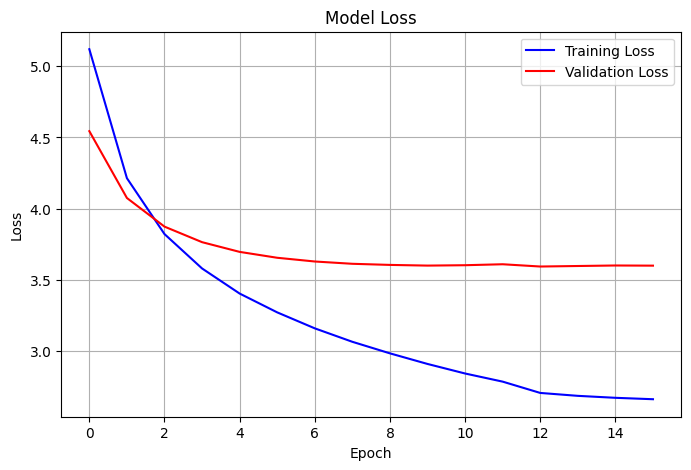

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Save Model

In [ ]:
model.save("/content/drive/MyDrive/image_captioning/model.keras")
print("Model saved!")

Model saved!


# Save Tokenizer

In [ ]:
with open('/content/drive/MyDrive/image_captioning/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# load Model

In [ ]:
model = load_model("/content/drive/MyDrive/image_captioning/model.keras")
print("Model loaded!")

Model loaded!


# load Tokenizer

In [ ]:
with open('/content/drive/MyDrive/image_captioning/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Generate caption for images

In [ ]:
# FAST index → word dictionary
index_word = {v: k for k, v in tokenizer.word_index.items()}

In [ ]:
def predict_caption(model, image_feature, tokenizer, index_word, max_length):
    in_text = "start"

    # Ensure feature shape → (1, 2048)
    image_input = np.expand_dims(image_feature, axis=0)

    for _ in range(max_length):

        # Convert current text to sequence
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')

        # Predict next word
        yhat = model.predict([image_input, seq], verbose=0)
        yhat = np.argmax(yhat)

        # Fast lookup
        word = index_word.get(yhat)

        if word is None:
            break

        in_text += " " + word

        # Stop if "end" word predicted
        if word == "end":
            break

    # Remove start/end tokens
    final = in_text.replace("start ", "").replace(" end", "")
    return final

# Validate with test data using BLEU score

In [ ]:
actual,predicted = list(),list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]

  # predict caption for image
  y_pred = predict_caption(model, features[key], tokenizer,index_word, max_length)

  # split into words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()

  # appned to list
  actual.append(actual_captions)
  predicted.append(y_pred)


# calculate BLEU score
from nltk.translate.bleu_score import corpus_bleu
score = corpus_bleu(actual, predicted)
score

  0%|          | 0/1000 [00:00<?, ?it/s]

0.18188619334105702

# Generate caption of Unseen Image

In [ ]:
from PIL import Image

def generate_caption(image_name):
  img_id = image_name.split(".")[0]
  img_path = os.path.join("/content/drive/MyDrive/val2017", image_name)
  image = Image.open(img_path)
  captions = mapping[img_id]
  print("---Actual Captions---")
  for caption in captions:
    print(caption)

  y_pred = predict_caption(model, features[img_id], tokenizer,index_word, max_length)
  print("---Predicted Caption---")
  print(y_pred)
  plt.imshow(image)

---Actual Captions---
start a person on skis skiing down a mountain slope end
start a man is skiing on the snow slopes end
start a skier is in the snow going downhill end
start a person with green skis skiing down a big hill end
start a person on skis is skiing down a snowy hill end
---Predicted Caption---
a person on skis on a snowy slope


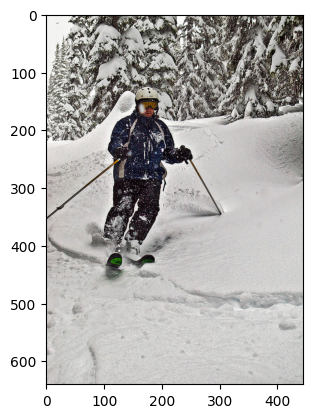

In [ ]:
generate_caption("000000005529.jpg")

---Actual Captions---
start a woman stands in the dining area at the table end
start a room with chairs a table and a woman in it end
start a woman standing in a kitchen by a window end
start a person standing at a table in a room end
start a living area with a television and a table end
---Predicted Caption---
a living room with a fireplace and a television


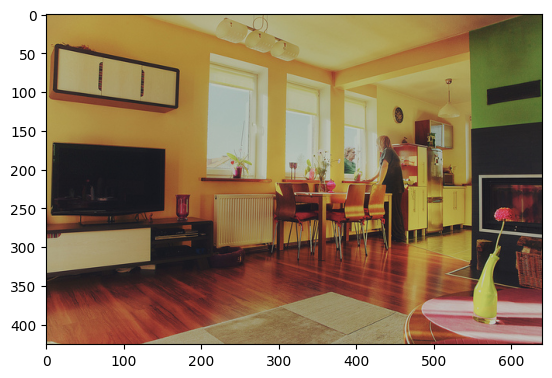

In [ ]:
generate_caption("000000000139.jpg")